# Fire Pulse Analysis
**Synopsis:** This python notebook will read in fire pulse data for processing and analysis.

**Abstract:** Fire pulse data taken from various tests will be processed and analyzed to show the similarity of the characteristics of fire pulse from the Navy Safety Fire Set firing into a LEEFI or CVR compared to the NAWC FTSA when firing into a CVR for qualification and acceptance testing. Five fire pulses will be analyzed.  All the fire pulses were taken at ambient temperature. These are:
- FIRE 800V: The highest stimulus successful fire pulse from the Neyer tests.
- FIRE 720V: The lowest stimulus successful fire pulse from the Neyer tests.
- CP 1000V: not sure
- RING 1000V: NSFS ring down into CVR
- FTSA Fire Pulse: A sample of the FTSA fire pulse taken during acceptance testing.

**Introduction:**  The purpose of this analysis is to show that the current viewing resistor (CVR) used for acceptance and qualification testing represents an adequate load that simulates a low energy exploding foil initiator (LEEFI).  The LEEFI is an explosive device that accepts a high voltage impulse from the rapid discharge of a capacitor and initiates a detonation wave used to initiate a secondary explosive device or that is propagated down a detonation cord.  This analysis will compare the peak amplitude of the stimulus pulse and the rise time measured during the explosive initiation reliability tests to the fire pulse measured into a CVR.  A LEEFI is a one time use explosive device and cannot be used for normal testing of the fight termination safe and arm (FTSA).  This analysis will show that the CVR is a suitable substitute for the LEEFI when performing functional tests of the FTSA.

**Scope:** The data analyzed was taken at ambient temperature.  Data at hot (81°C) and cold (-54°C) temperatures was not made available for this analysis.  While the data is different at hot and cold temperatures the results will be similar in so far as the pulse shape should track with temperature.

**Analysis method:** The method used to establish that the CVR does represent an actual LEEFI is to compare shape of the leading edge of the fire pulse from data taken during actual firing to data from a CVR.  First the fire pulse data will be normalized and time aligned to the peak of the pulse.  The fire pulses will be plotted on a common graph so that the general shape of the data can be visually inspected.  Then the rise time of the leading edge of the fire pulse will be calculated from the data.  For this analysis the rise time is taken to be the time difference between the 10% and 90% points on the leading edge of the pulse.  Finally the root-mean-square error (RMSE) will be computed between the FIRE_800V data set and the others.


# Python code
[Python](https://en.wikipedia.org/wiki/Python_(programming_language) is a widely used high-level programming language for general-purpose programming, created by Guido van Rossum and first released in 1991. An interpreted language, Python has a design philosophy that emphasizes code readability (notably using whitespace indentation to delimit code blocks rather than curly brackets or keywords), and a syntax that allows programmers to express concepts in fewer lines of code than might be used in languages such as C++ or Java. The language provides constructs intended to enable writing clear programs on both a small and large scale.  Python features a dynamic type system and automatic memory management and supports multiple programming paradigms, including object-oriented, imperative, functional programming, and procedural styles. It has a large and comprehensive standard library.

## Load some python modules
These modules are from the [SciPy](https://en.wikipedia.org/wiki/SciPy) open source Python library.  [SciPy](https://www.scipy.org/) (pronounced "Sigh Pie") is an open source Python library used for scientific computing and technical computing. SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.  SciPy builds on the NumPy array object and is part of the NumPy stack which includes tools like Matplotlib, pandas and SymPy, and an expanding set of scientific computing libraries. This NumPy stack has similar users to other applications such as MATLAB, GNU Octave, and Scilab. The NumPy stack is also sometimes referred to as the SciPy stack.

In [21]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

## Load fire pulse data from files
Fire pulse data was previously sliced from much longer data sets and saved to files.  Here only the main pulse is loaded.

In [22]:
df1 = pd.read_pickle('FIRE_800V.pkl')
df2 = pd.read_pickle('FIRE_720V.pkl')
df3 = pd.read_pickle('FTSA Fire Pulse.pkl')
df4 = pd.read_pickle('RING_1000V.pkl')
df5 = pd.read_pickle('CP_1000V.pkl')

## Normalize and time align the data
- normalize data to 1
- convert time base to nsec
- time align peak to t=0

In [23]:
# FIRE 800V
x1 = df1['Time'].values
y1 = df1['Voltage'].values
y1 = y1/y1.max()
x1 *= 1e9
y1_peak_index = y1.argmax()
x1 -= x1[y1_peak_index]

In [24]:
# FIRE 720V
x2 = df2['Time'].values
y2 = df2['Voltage'].values
y2 = y2/y2.max()
x2 *= 1e9
y2_peak_index = y2.argmax()
x2 -= x2[y2_peak_index]

In [25]:
# FTSA Fire Pulse
x3 = df3['Time'].values
y3 = df3['Voltage'].values
y3 = y3/y3.max()
y3_peak_index = y3.argmax()
x3 -= x3[y3_peak_index]
#x3[:] -= x3[0]  #start time at zero
#x3 += 88 #shift by 8 ns

In [26]:
#RING 1000V
x4 = df4['Time'].values
y4 = df4['Current'].values
y4 = y4/y4.max()
x4 *= 1e9
y4_peak_index = y4.argmax()
x4 -= x4[y4_peak_index]

In [27]:
#CP 1000V
x5 = df5['Time'].values
y5 = df5['Voltage'].values
y5 = y5/y5.max()
x5 *= 1e9
y5_peak_index = y5.argmax()
x5 -= x5[y5_peak_index]

## Plot the data

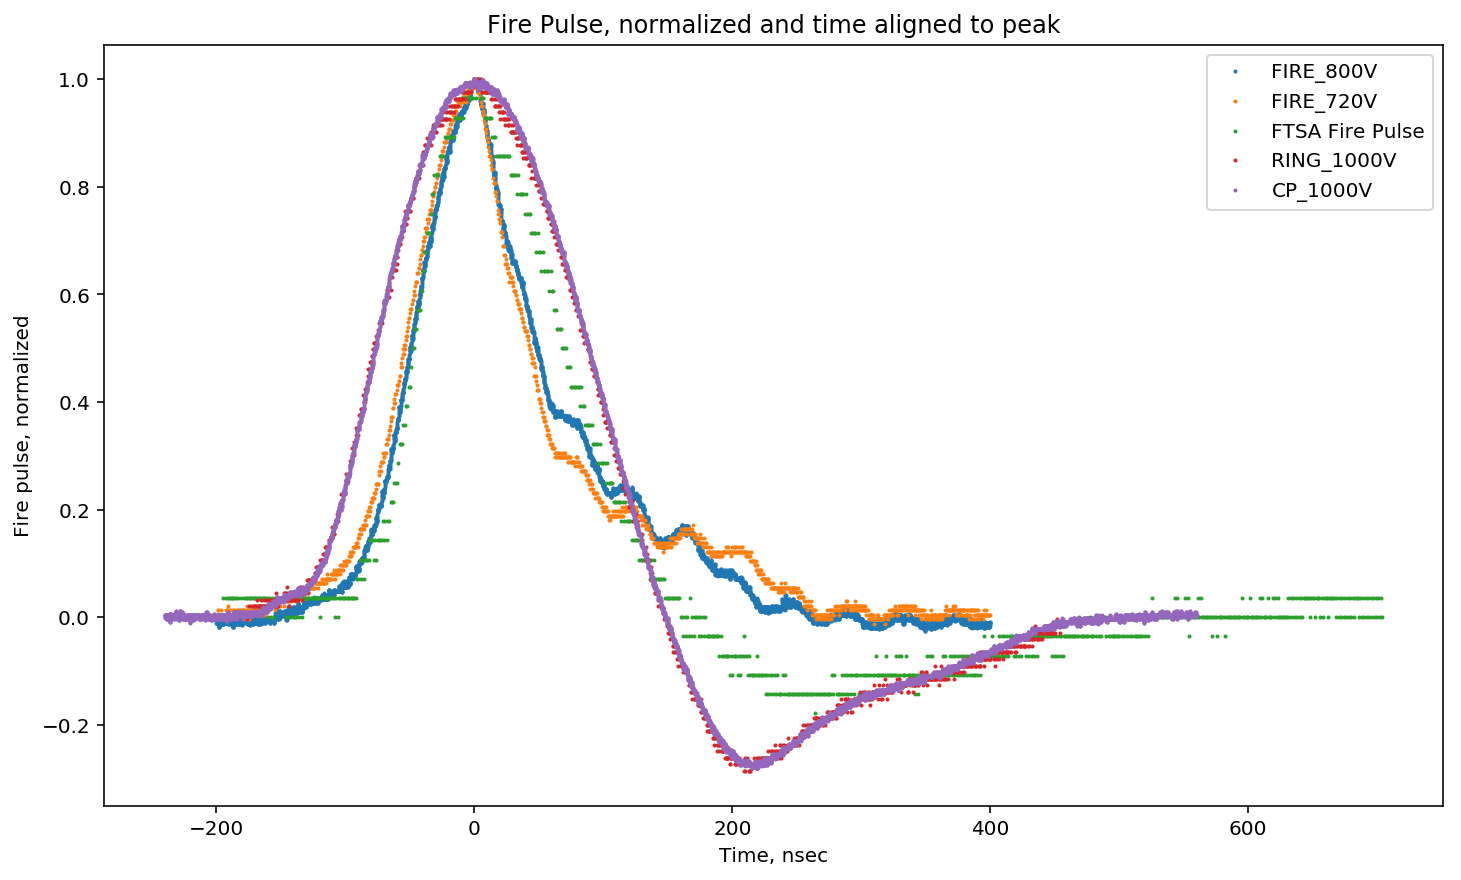

In [28]:
# plot the fire pulse
plt.plot(x1,y1,'o', markersize=1)
plt.plot(x2,y2,'o', markersize=1)
plt.plot(x3,y3,'o', markersize=1)
plt.plot(x4,y4,'o', markersize=1)
plt.plot(x5,y5,'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'FTSA Fire Pulse', 'RING_1000V', 'CP_1000V'], loc='best')
plt.title('Fire Pulse, normalized and time aligned to peak')
plt.show()

Comments:  The RING_1000V and CP_1000V data have a different shape compared to the fire pulse into a LEEFI (FIRE_800V and FIRE_720V) or the pulse into a CVR.

## Plotting only the leading edge of the fire pulses

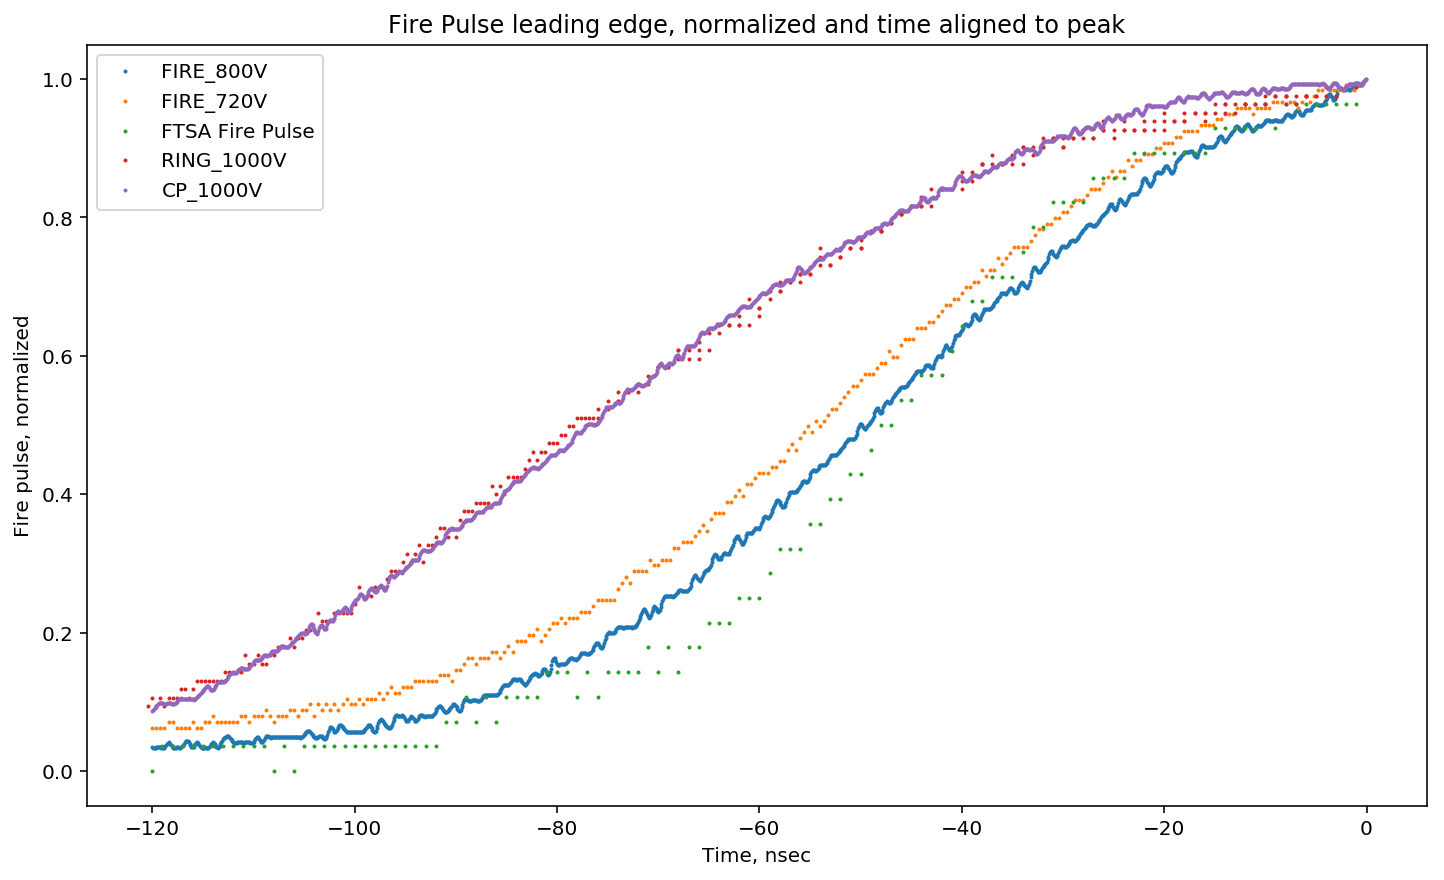

In [29]:
# plot the fire pulse
plt.plot(x1[y1_peak_index-1500:y1_peak_index],y1[y1_peak_index-1500:y1_peak_index],'o', markersize=1)
plt.plot(x2[y2_peak_index-300:y2_peak_index],y2[y2_peak_index-300:y2_peak_index],'o', markersize=1)
plt.plot(x3[y3_peak_index-120:y3_peak_index],y3[y3_peak_index-120:y3_peak_index],'o', markersize=1)
plt.plot(x4[y4_peak_index-300:y4_peak_index],y4[y4_peak_index-300:y4_peak_index],'o', markersize=1)
plt.plot(x5[y5_peak_index-1500:y5_peak_index],y5[y5_peak_index-1500:y5_peak_index],'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'FTSA Fire Pulse', 'RING_1000V', 'CP_1000V'], loc='best')
plt.title('Fire Pulse leading edge, normalized and time aligned to peak')
plt.show()

## Calculate rise time

The rise time will be calculated on the smoothed data set.  A Savitzky–Golay filter was be used to smooth the data.

A [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the signal-to-noise ratio without greatly distorting the signal. This is achieved, in a process known as convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

### Rise time for FIRE_800V

In [30]:
# consider only the rising edge
x1_rise = x1[y1_peak_index-1500:y1_peak_index]
y1_rise = y1[y1_peak_index-1500:y1_peak_index]

y1_filtered = savgol_filter(y1_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y1_filtered-y1_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y1_filtered-y1_filtered.max()*0.1)).argmin()
rise_time = x1_rise[index_90pc]-x1_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y1_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_90pc], x1_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_10pc], x1_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.997 volts
90% voltage value: 0.897 volts at -16 ns
10% voltage value: 0.099 volts at -89 ns
rise time: 72 ns


#### Plot the 90% and 10% points on the curve

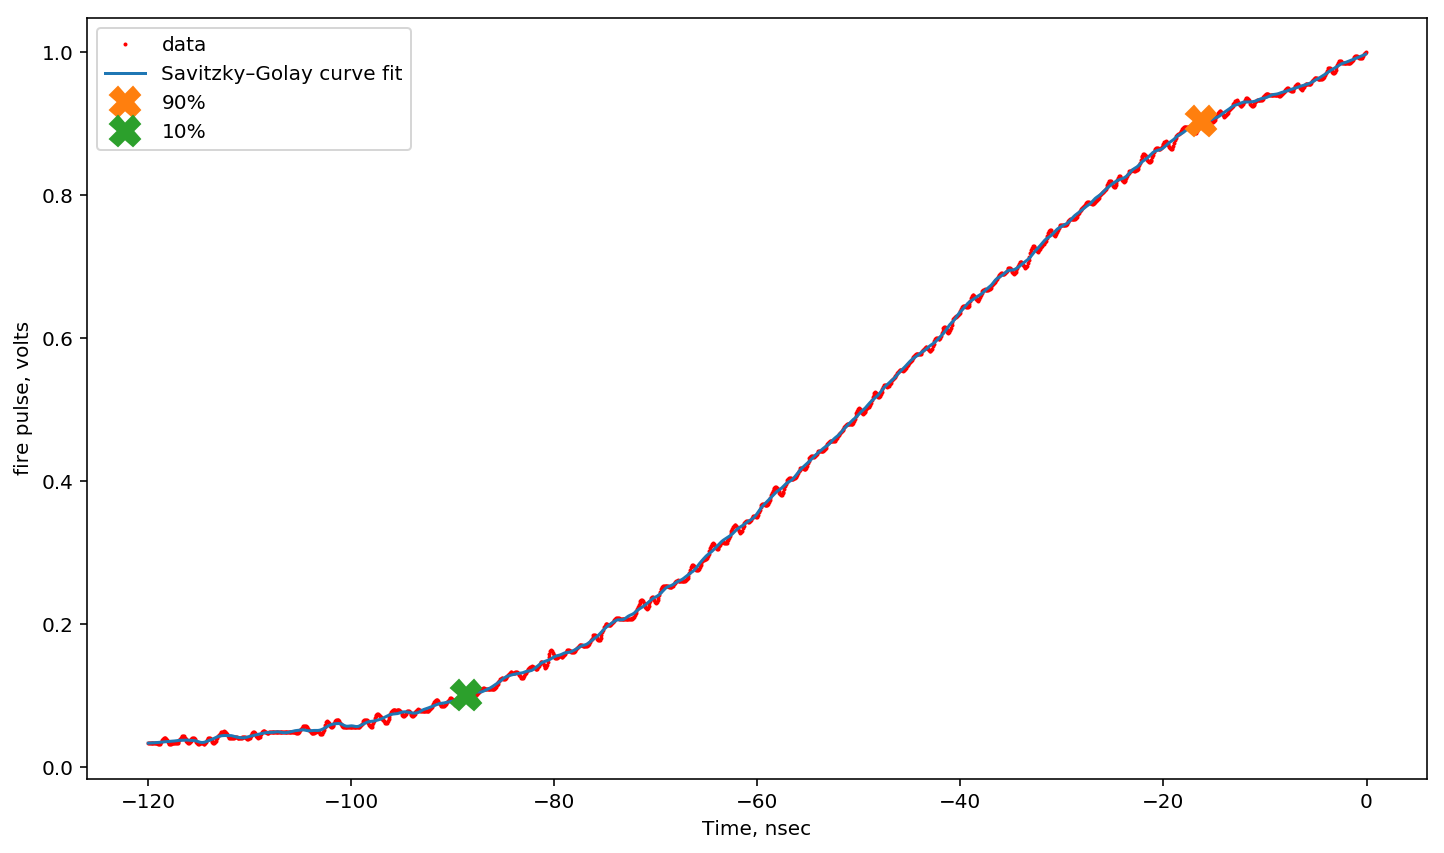

In [31]:
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.plot(x1_rise,y1_filtered)
plt.plot(x1_rise[index_90pc],y1_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x1_rise[index_10pc],y1_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

### Rise time for FIRE_720V

In [32]:
# consider only the rising edge
x2_rise = x2[y2_peak_index-300:y2_peak_index]
y2_rise = y2[y2_peak_index-300:y2_peak_index]

y2_filtered = savgol_filter(y2_rise, 51, 3)  # filter the data
index_90pc = (np.abs(y2_filtered-y2_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y2_filtered-y2_filtered.max()*0.1)).argmin()
rise_time = x2_rise[index_90pc]-x2_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_90pc], x2_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_10pc], x2_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.895 volts at -21 ns
10% voltage value: 0.099 volts at -100 ns
rise time: 79 ns


#### Plot the 90% and 10% points on the curve

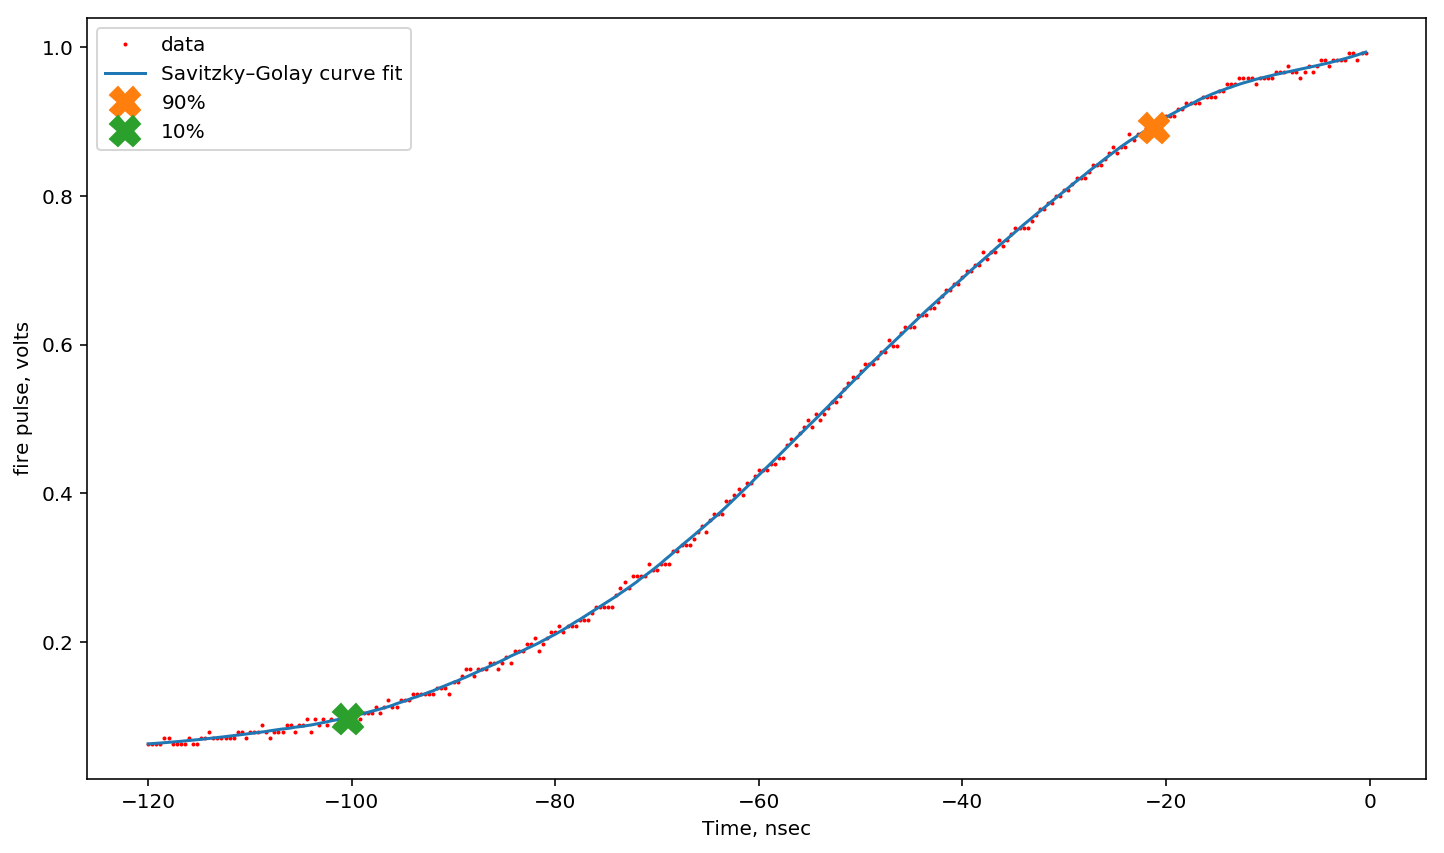

In [33]:
plt.plot(x2_rise,y2_rise,'ro', markersize=1)
plt.plot(x2_rise,y2_filtered)
plt.plot(x2_rise[index_90pc],y2_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x2_rise[index_10pc],y2_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

### Rise time for FTSA fire pulse

In [34]:
# consider only the rising edge
x3_rise = x3[y3_peak_index-120:y3_peak_index]
y3_rise = y3[y3_peak_index-120:y3_peak_index]

y3_filtered = savgol_filter(y3_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y3_filtered-y3_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y3_filtered-y3_filtered.max()*0.1)).argmin()
rise_time = x3_rise[index_90pc]-x3_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_90pc], x3_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_10pc], x3_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.864 volts at -24 ns
10% voltage value: 0.097 volts at -83 ns
rise time: 59 ns


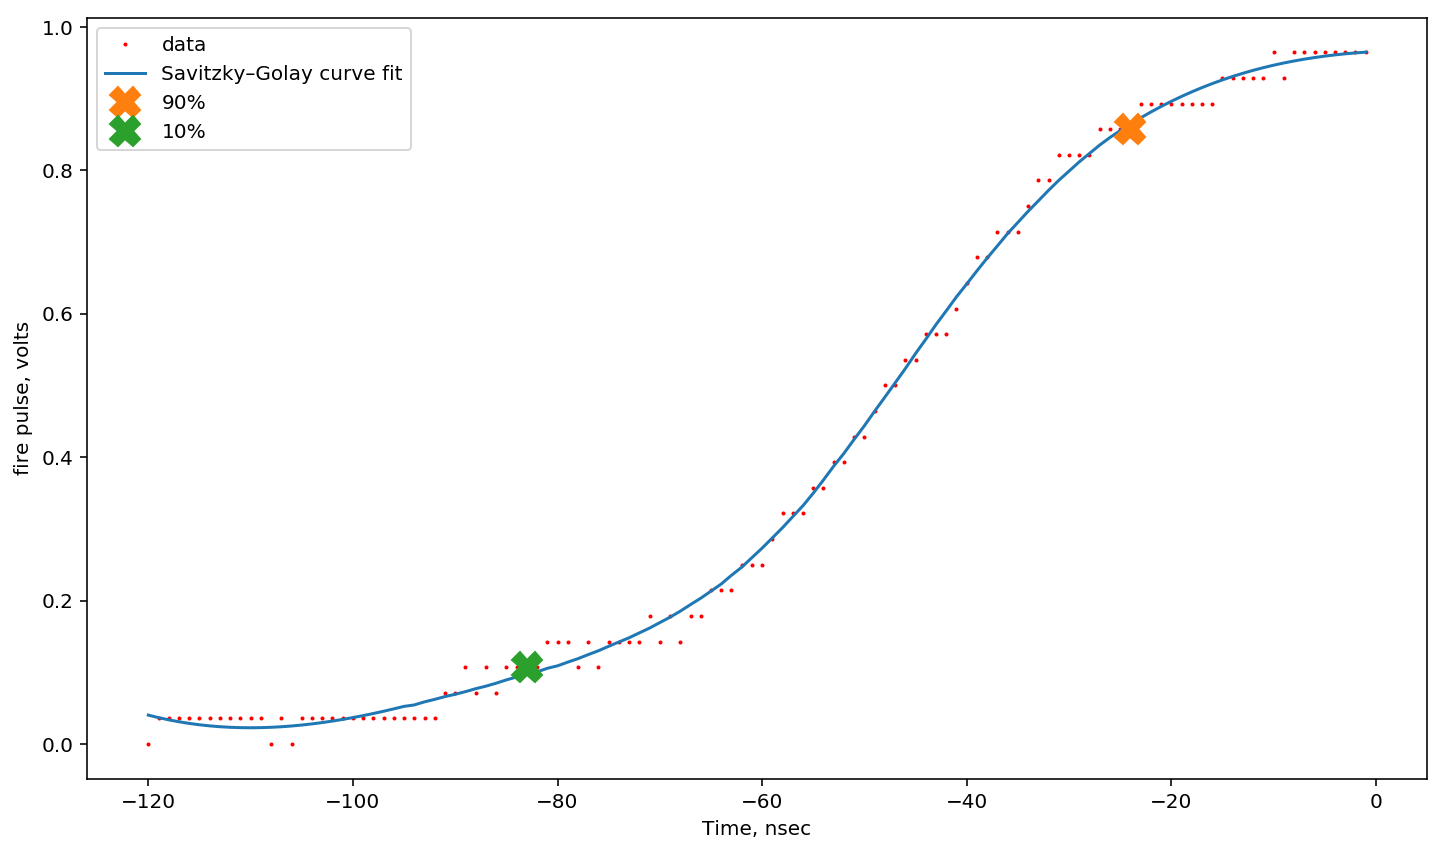

In [36]:
plt.plot(x3_rise,y3_rise,'ro', markersize=1)
plt.plot(x3_rise,y3_filtered)
plt.plot(x3_rise[index_90pc],y3_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x3_rise[index_10pc],y3_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

### correlation
Tried several approaches. Tried the Pearson correlation coefficient, but this assumes that there is a linear relationship between the datasets, which there isn't.

needed to made the data set the same length

In [52]:
import scipy.stats
from scipy.interpolate import interp1d

In [53]:
len(y1_rise)

1500

In [54]:
len(y2_rise)

300

In [65]:
len(y2_rise)

300

In [70]:
y2_rise_resampled = scipy.signal.resample(y2_rise, len(y1_rise), t=None, axis=0, window=None)

In [72]:
len(y2_rise_resampled)

1500

In [73]:
scipy.stats.pearsonr(y1_rise, y2_rise_resampled)

(0.99445167916915278, 0.0)

In [74]:
y3_filtered_resampled = scipy.signal.resample(y3_filtered, len(y1_rise), t=None, axis=0, window=None)

In [75]:
scipy.stats.pearsonr(y1_rise, y3_filtered_resampled)

(0.98571375276791429, 0.0)

Measuring Nonlinear Relations. What do you do if a correlation is strong but clearly nonlinear (as concluded from examining scatterplots)? Unfortunately, there is no simple answer to this question, because there is no easy-to-use equivalent of Pearson r that is capable of handling nonlinear relations. If the curve is monotonous (continuously decreasing or increasing) you could try to transform one or both of the variables to remove the curvilinearity and then recalculate the correlation. For example, a typical transformation used in such cases is the logarithmic function which will "squeeze" together the values at one end of the range. Another option available if the relation is monotonous is to try a nonparametric correlation (e.g., Spearman R, see Nonparametrics and Distribution Fitting) which is sensitive only to the ordinal arrangement of values, thus, by definition, it ignores monotonous curvilinearity. However, nonparametric correlations are generally less sensitive and sometimes this method will not produce any gains. Unfortunately, the two most precise methods are not easy to use and require a good deal of "experimentation" with the data. Therefore you could:

Try to identify the specific function that best describes the curve. After a function has been found, you can test its "goodness-of-fit" to your data.
Alternatively, you could experiment with dividing one of the variables into a number of segments (e.g., 4 or 5) of an equal width, treat this new variable as a grouping variable and run an analysis of variance on the data.

### try a poly fit to the FIRE 800V rising edge data

In [92]:
# fitting the data to a poly
z = np.polyfit(x1_rise, y1_rise, 5)
z

array([  1.92259420e-10,   4.58821885e-08,   2.06990050e-06,
        -1.19829520e-04,   3.23080580e-03,   9.86418889e-01])

In [93]:
# convert it to a function
fx = np.poly1d(z)

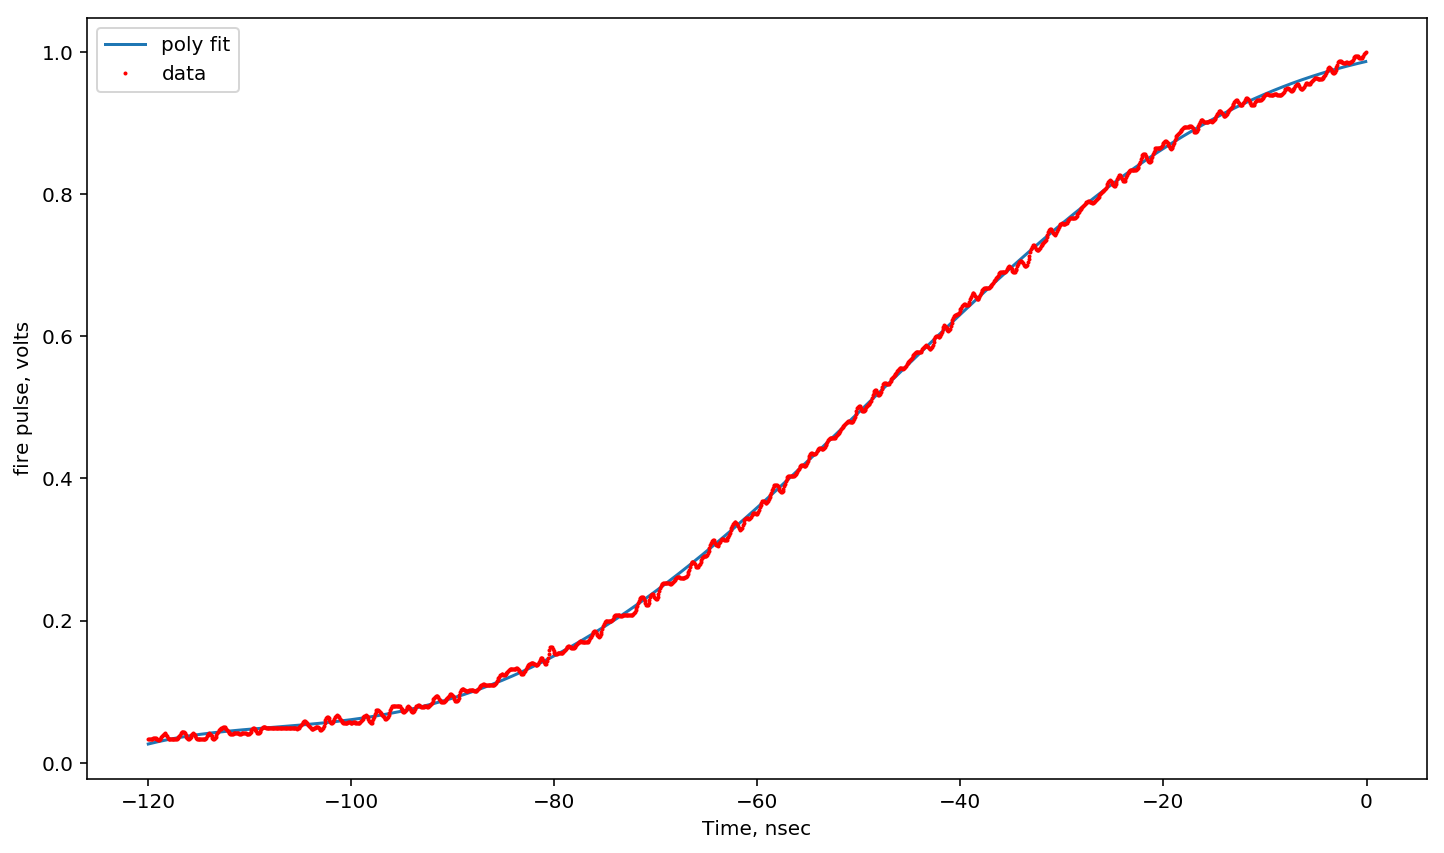

In [95]:
#plot the poly
xp = np.linspace(x1_rise[0], x1_rise[-1], 500)
plt.plot(xp, fx(xp), '-')
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['poly fit', 'data','90%','10%'], loc='best')
plt.show()

The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample and population values) predicted by a model or an estimator and the values actually observed. The RMSD represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation, and are called prediction errors when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular data and not between datasets, as it is scale-dependent.

Although RMSE is one of the most commonly reported measures of disagreement, some scientists misinterpret RMSD as average error, which RMSD is not. RMSD is the square root of the average of squared errors, thus RMSD confounds information concerning average error with information concerning variation in the errors. The effect of each error on RMSD is proportional to the size of the squared error thus larger errors have a disproportionately large effect on RMSD. Consequently, RMSD is sensitive to outliers.

In [96]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [97]:
# between y1 and y1
rmse(y1_rise, y1_rise)

0.0

In [98]:
# between y1 and fx
xp = np.linspace(x1_rise[0], x1_rise[-1], len(y1_rise))
rmse(y1_rise, fx(xp))

0.005327652281802567

In [99]:
# between y2 and fx
xp = np.linspace(x2_rise[0], x2_rise[-1], len(y2_rise))
rmse(y2_rise, fx(xp))

0.0502130803382283

In [101]:
# between y3 and fx
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
rmse(y3_rise, fx(xp))

0.047251018193380616

In [102]:
# between y3 and fx
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
rmse(y3_filtered, fx(xp))

0.042257434937065588

In [103]:
rmse(y1_rise, y2_rise_resampled)

0.057911616273891027

In [105]:
rmse(y1_rise, y3_filtered_resampled)

0.066082708259843387

### Calculate peak voltage

In [119]:
x1

array([], dtype=float64)

### Try to fit a 2nd order curve to the data

In [146]:
# fitting the data to a poly
start = 1500
stop = 4000
znd = np.polyfit(x1[start:stop], y1[start:stop], 5)
znd

array([ -1.30622216e-10,   1.71204867e-08,   1.35436509e-06,
        -2.13523057e-04,  -2.60684828e-03,   9.20026141e-01])

In [147]:
# convert it to a function
fx2 = np.poly1d(znd)

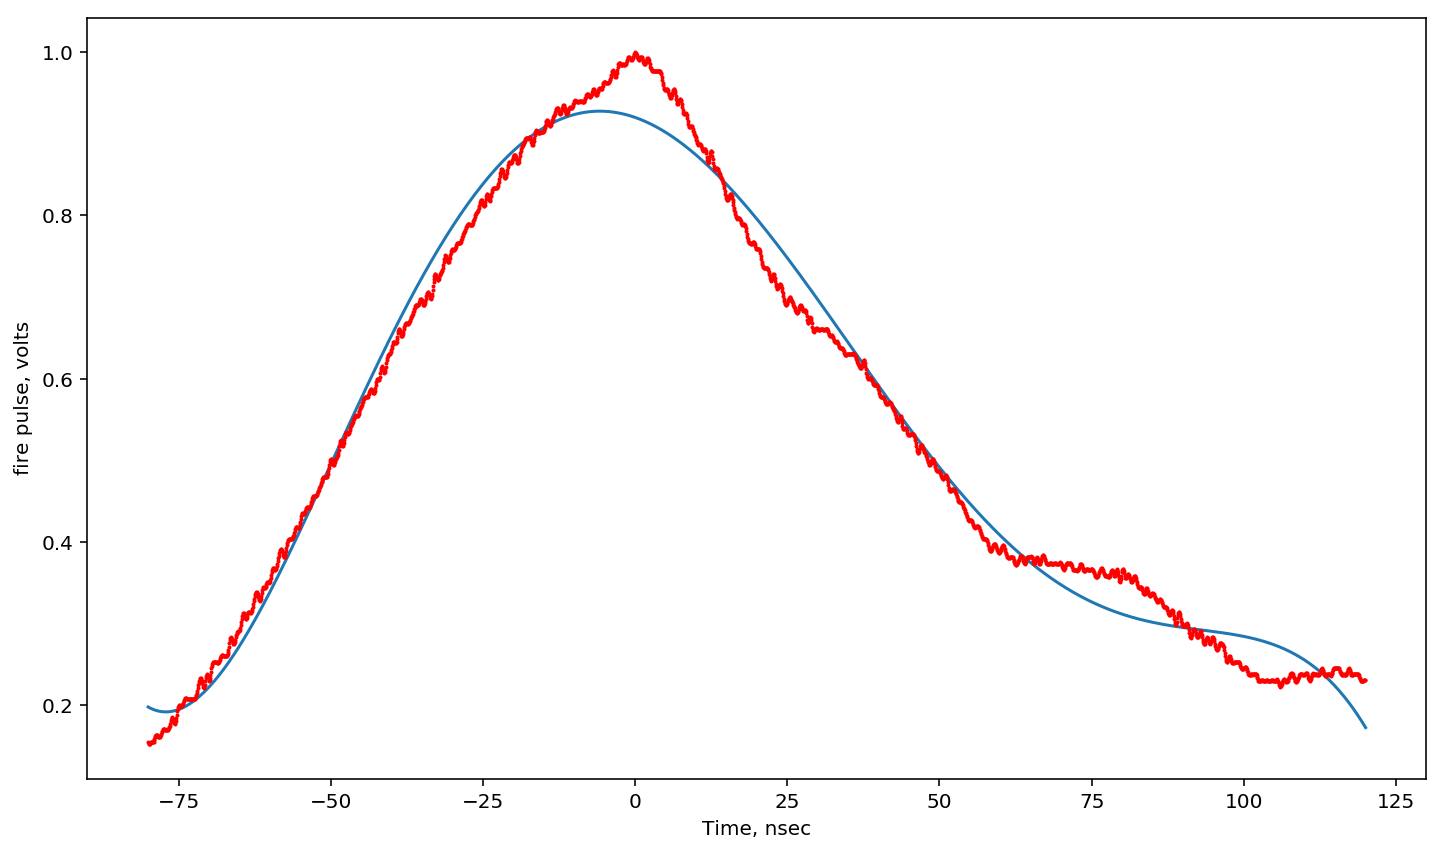

In [148]:

#plot the poly
xp = np.linspace(x1[start], x1[stop], 500)
plt.plot(xp, fx2(xp), '-')
plt.plot(x1[start:stop],y1[start:stop],'ro', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.show()

OLD CODE BELOW HERE
-------------------

In [7]:
len(csv1)

25000

In [8]:
time = csv1[3].values
time = time.astype(float)
voltage = csv1[4].values
voltage = voltage.astype(float)

In [9]:
print('number of points in the data set: {:,d}'.format(len(voltage)))
print('peak voltage: {:.3f}'.format(voltage.max()))

number of points in the data set: 25,000
peak voltage: 1.060


### Find the offset voltage.
From the peak time t, find the averge from t-300 to t-200.

In [5]:
peak_index = voltage.argmax()
start = peak_index-300
end = peak_index-200
x = time[start:end]
y = voltage[start:end]
offset= y.mean()
print('voltage offset: {:.3f} volts'.format(offset))

In [6]:
# plot base line data, pre pulse, with offset
plt.plot(x,y,'ro', markersize=4)
plt.xlabel('Time, nsec')
plt.ylabel('Voltage')
plt.legend(['data'], loc='best')
plt.show()

In [7]:
start = peak_index-200
end = peak_index+700
x = time[start:end]
y = voltage[start:end]
y -= offset  #remove the offset

A [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the signal-to-noise ratio without greatly distorting the signal. This is achieved, in a process known as convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares. When the data points are equally spaced, an analytical solution to the least-squares equations can be found, in the form of a single set of "convolution coefficients" that can be applied to all data sub-sets, to give estimates of the smoothed signal, (or derivatives of the smoothed signal) at the central point of each sub-set. The method, based on established mathematical procedures, was popularized by Abraham Savitzky and Marcel J. E. Golay who published tables of convolution coefficients for various polynomials and sub-set sizes in 1964.

In [8]:
ynew = savgol_filter(y, 51, 3)  # filter the data

In [9]:
ynew = savgol_filter(y, 51, 3)  # filter the data
# plot the fire pulse
plt.plot(x,y,'ro', markersize=1)
plt.plot(x,ynew)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data','Savitzky–Golay curve fit'], loc='best')
plt.show()

### find the following:
1. peak voltage
2. average pre pulse voltage level
3. index of 90% of peak
4. find 10% index
5. calculate rise time
6. calculate peak current

In [10]:
peak = y.max()
peak_index = y.argmax()+5
print('peak voltage: {:.3f}'.format(peak))
print('index of peak: {:.3f}'.format(peak_index))

#### limit data set to index of peak

In [11]:
x1 = x[50:peak_index]-x[50]
y1 = y[50:peak_index]

# plot the fire pulse
y1new = savgol_filter(y1, 51, 3)
plt.plot(x1,y1,'ro', markersize=1)
plt.plot(x1,y1new)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data','Savitzky–Golay curve fit'], loc='best')
plt.show()

#### find rise time

In [14]:
index_90pc = (np.abs(y1new-y1new.max()*0.9)).argmin()
index_10pc = (np.abs(y1new-y1new.max()*0.1)).argmin()
rise_time = x1[index_90pc]-x1[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y1new.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y1new[index_90pc], x1[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y1new[index_10pc], x1[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

#### plot the 90% and 10% data points

In [15]:
# plot the fire pulse
plt.plot(x1,y1,'ro', markersize=1)
plt.plot(x1,y1new)
plt.plot(x1[index_90pc],y1new[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x1[index_10pc],y1new[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data','Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

CVR: R1 = 0.5143, R2 = 0.004907

In [19]:
R1 = 0.5143
R2 = 0.004907
print('peak current: {:,.0f} amps'.format(peak/R2))
print('peak voltage across the CVR: {:,.0f} volts'.format((R1+R2)*peak/R2))